In [17]:
import pandas as pd
import numpy as np
pd.options.display.max_colwidth = 400
df = pd.read_csv("output/result.csv", header=None)
df.columns = ['target',
              'query',
              'explanation',
              'status',
              'test accuracy',
              'rnn score',
              'explanation score',
              'explanation score on ground truth',
              'extraction time',
              'revised delta',
              'revised epsilon',
              'counterexamples',
              'train size',
              'test size',
              'ltl_depth',
            'lstar states',
            'lstar explanation score',
            'lstar explanation score on ground truth',
            'lstar extraction time',
            'lstar status', 
            'epsilon', 
            'delta'
              ]






('F(a)', 'true', 0.05)
             explanation  extraction time  explanation score  epsilon  delta
 ((b | c) U (~ (b | c)))         2.706867              100.0     0.05   0.05
 ((b | c) U (~ (b | c)))         2.376391              100.0     0.10   0.05
 ((b | c) U (~ (b | c)))         2.114177              100.0     0.25   0.05
 ((b | c) U (~ (b | c)))         2.100703              100.0     0.50   0.05


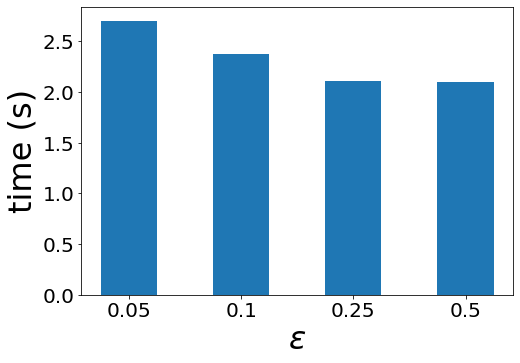





('F(a)', 'true', 0.05)
             explanation  extraction time  explanation score  epsilon  delta
 ((b | c) U (~ (b | c)))         2.706867              100.0     0.05   0.05
 ((b | c) U (~ (b | c)))         2.817450              100.0     0.05   0.10
 ((b | c) U (~ (b | c)))         2.663990              100.0     0.05   0.25
 ((b | c) U (~ (b | c)))         2.491019              100.0     0.05   0.50


<Figure size 432x288 with 0 Axes>

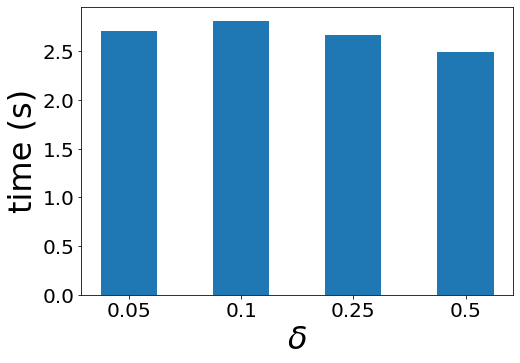





('F(a)', 'true', 0.1)
             explanation  extraction time  explanation score  epsilon  delta
 ((b | c) U (~ (b | c)))         2.817450              100.0     0.05    0.1
 ((b | c) U (~ (b | c)))         2.374882              100.0     0.10    0.1
 ((b | c) U (~ (b | c)))         2.146039              100.0     0.25    0.1
 ((b | c) U (~ (b | c)))         2.096846              100.0     0.50    0.1


<Figure size 432x288 with 0 Axes>

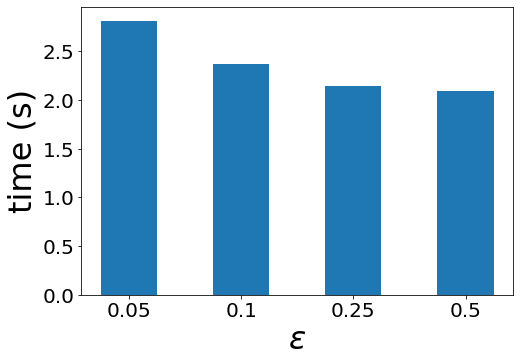





('F(a)', 'true', 0.1)
                                 explanation  extraction time  explanation score  epsilon  delta
                     ((b | c) U (~ (b | c)))         2.376391             100.00      0.1   0.05
                     ((b | c) U (~ (b | c)))         2.374882             100.00      0.1   0.10
 ((c | (X c)) U (b U (~ (b | (c | (X c))))))       401.051040              85.42      0.1   0.25
                     ((b | c) U (~ (b | c)))         2.191779             100.00      0.1   0.50


<Figure size 432x288 with 0 Axes>

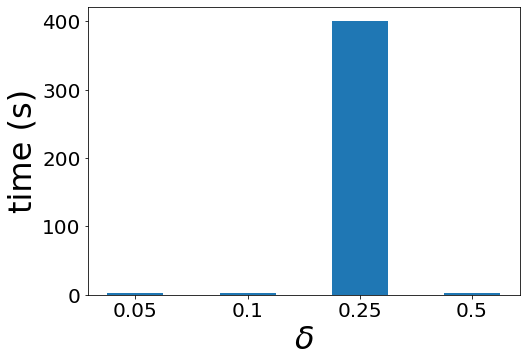





('F(a)', 'true', 0.25)
                                 explanation  extraction time  explanation score  epsilon  delta
                     ((b | c) U (~ (b | c)))         2.663990             100.00     0.05   0.25
 ((c | (X c)) U (b U (~ (b | (c | (X c))))))       401.051040              85.42     0.10   0.25
                             (~ (G (b | c)))         1.515361             100.00     0.25   0.25
                             (F (~ (b | c)))         1.513672             100.00     0.50   0.25


<Figure size 432x288 with 0 Axes>

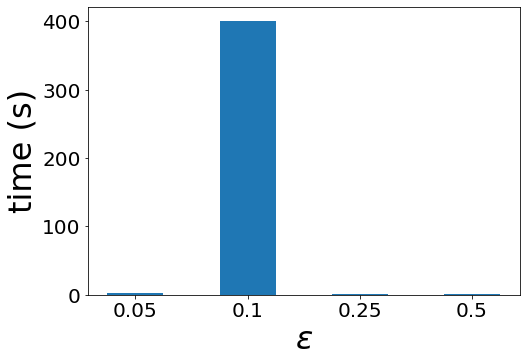





('F(a)', 'true', 0.25)
             explanation  extraction time  explanation score  epsilon  delta
 ((b | c) U (~ (b | c)))         2.114177              100.0     0.25   0.05
 ((b | c) U (~ (b | c)))         2.146039              100.0     0.25   0.10
         (~ (G (b | c)))         1.515361              100.0     0.25   0.25
 ((b | c) U (~ (b | c)))         2.118025              100.0     0.25   0.50


<Figure size 432x288 with 0 Axes>

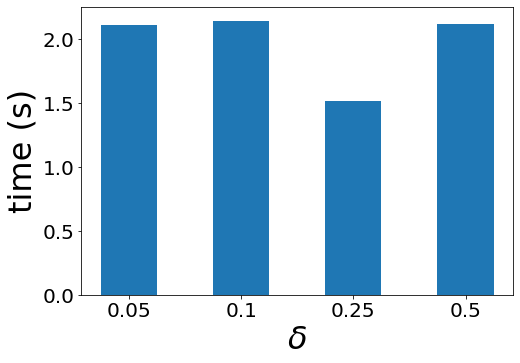





('F(a)', 'true', 0.5)
             explanation  extraction time  explanation score  epsilon  delta
 ((b | c) U (~ (b | c)))         2.491019              100.0     0.05    0.5
 ((b | c) U (~ (b | c)))         2.191779              100.0     0.10    0.5
 ((b | c) U (~ (b | c)))         2.118025              100.0     0.25    0.5
 ((b | c) U (~ (b | c)))         2.028477              100.0     0.50    0.5


<Figure size 432x288 with 0 Axes>

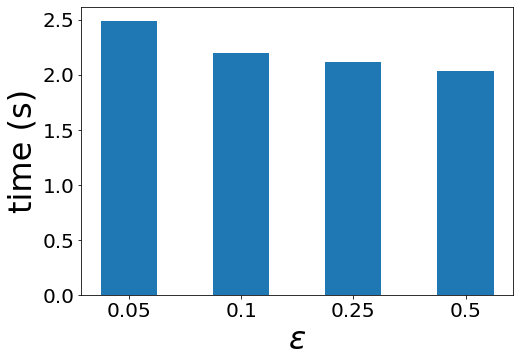





('F(a)', 'true', 0.5)
             explanation  extraction time  explanation score  epsilon  delta
 ((b | c) U (~ (b | c)))         2.100703              100.0      0.5   0.05
 ((b | c) U (~ (b | c)))         2.096846              100.0      0.5   0.10
         (F (~ (b | c)))         1.513672              100.0      0.5   0.25
 ((b | c) U (~ (b | c)))         2.028477              100.0      0.5   0.50


<Figure size 432x288 with 0 Axes>

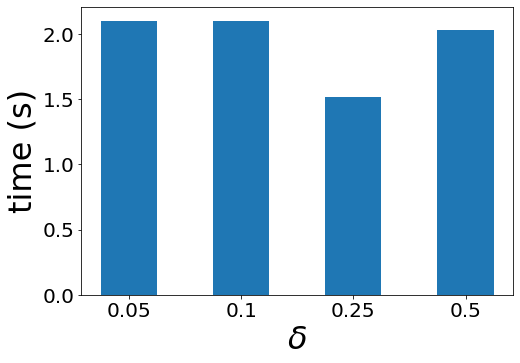





('F(aUb)', 'true', 0.05)
             explanation  extraction time  explanation score  epsilon  delta
 ((a | c) U (~ (a | c)))         2.061898              100.0     0.05   0.05
 ((a | c) U (~ (a | c)))         1.708025              100.0     0.10   0.05
         (~ (G (a | c)))         1.525635              100.0     0.25   0.05
         (~ (G (a | c)))         1.439474              100.0     0.50   0.05


<Figure size 432x288 with 0 Axes>

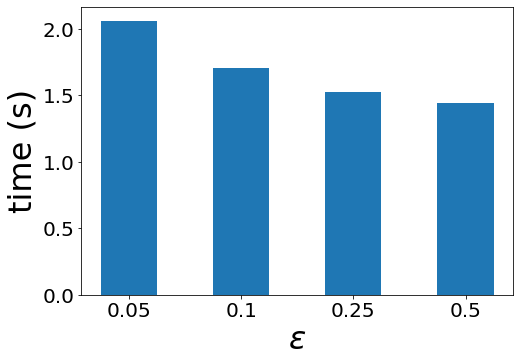





('F(aUb)', 'true', 0.05)
             explanation  extraction time  explanation score  epsilon  delta
 ((a | c) U (~ (a | c)))         2.061898              100.0     0.05   0.05
         (~ (G (a | c)))         2.014632              100.0     0.05   0.10
         (~ (G (a | c)))         1.866428              100.0     0.05   0.25
         (~ (G (a | c)))         1.799725              100.0     0.05   0.50


<Figure size 432x288 with 0 Axes>

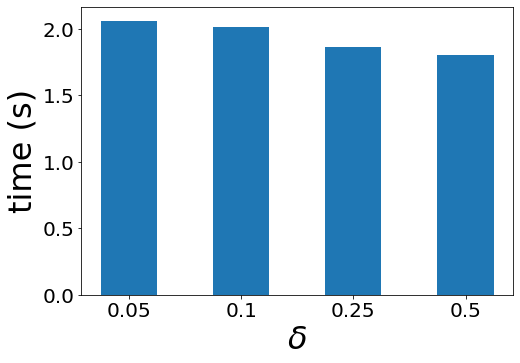





('F(aUb)', 'true', 0.1)
             explanation  extraction time  explanation score  epsilon  delta
         (~ (G (a | c)))         2.014632              100.0     0.05    0.1
 ((a | c) U (~ (a | c)))         1.679514              100.0     0.10    0.1
         (~ (G (a | c)))         1.558352              100.0     0.25    0.1
 ((a | c) U (~ (a | c)))         1.399990              100.0     0.50    0.1


<Figure size 432x288 with 0 Axes>

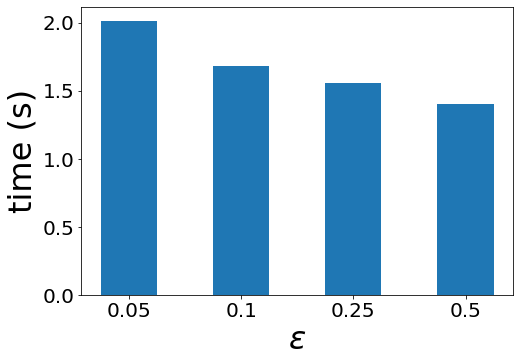





('F(aUb)', 'true', 0.1)
             explanation  extraction time  explanation score  epsilon  delta
 ((a | c) U (~ (a | c)))         1.708025              100.0      0.1   0.05
 ((a | c) U (~ (a | c)))         1.679514              100.0      0.1   0.10
         (~ (G (a | c)))         1.600716              100.0      0.1   0.25
 ((a | c) U (~ (a | c)))         1.605160              100.0      0.1   0.50


<Figure size 432x288 with 0 Axes>

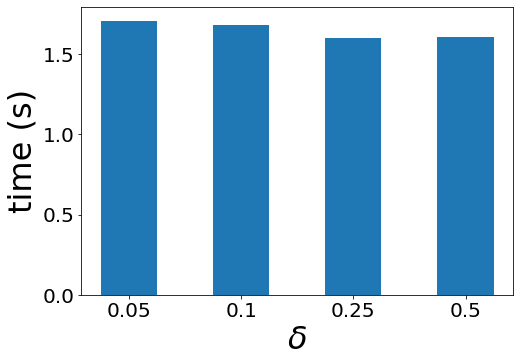





('F(aUb)', 'true', 0.25)
     explanation  extraction time  explanation score  epsilon  delta
 (~ (G (a | c)))         1.866428              100.0     0.05   0.25
 (~ (G (a | c)))         1.600716              100.0     0.10   0.25
 (~ (G (a | c)))         3.692021              100.0     0.25   0.25
 (~ (G (a | c)))         1.444050              100.0     0.50   0.25


<Figure size 432x288 with 0 Axes>

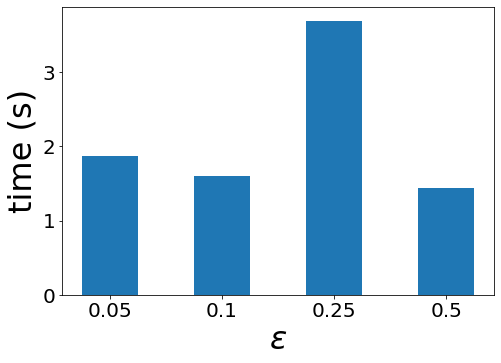





('F(aUb)', 'true', 0.25)
     explanation  extraction time  explanation score  epsilon  delta
 (~ (G (a | c)))         1.525635              100.0     0.25   0.05
 (~ (G (a | c)))         1.558352              100.0     0.25   0.10
 (~ (G (a | c)))         3.692021              100.0     0.25   0.25
 (~ (G (a | c)))         1.439413              100.0     0.25   0.50


<Figure size 432x288 with 0 Axes>

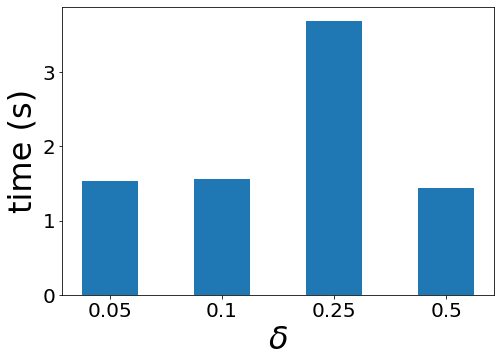





('F(aUb)', 'true', 0.5)
             explanation  extraction time  explanation score  epsilon  delta
         (~ (G (a | c)))         1.799725              100.0     0.05    0.5
 ((a | c) U (~ (a | c)))         1.605160              100.0     0.10    0.5
         (~ (G (a | c)))         1.439413              100.0     0.25    0.5
         (F (~ (a | c)))         2.833395              100.0     0.50    0.5


<Figure size 432x288 with 0 Axes>

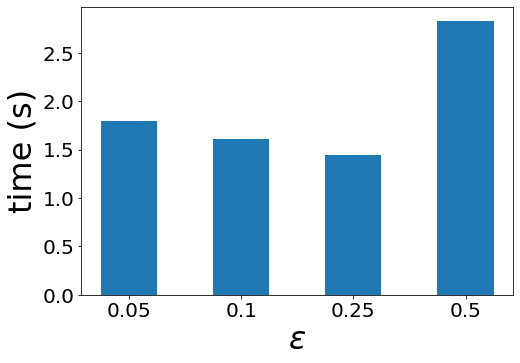





('F(aUb)', 'true', 0.5)
             explanation  extraction time  explanation score  epsilon  delta
         (~ (G (a | c)))         1.439474              100.0      0.5   0.05
 ((a | c) U (~ (a | c)))         1.399990              100.0      0.5   0.10
         (~ (G (a | c)))         1.444050              100.0      0.5   0.25
         (F (~ (a | c)))         2.833395              100.0      0.5   0.50


<Figure size 432x288 with 0 Axes>

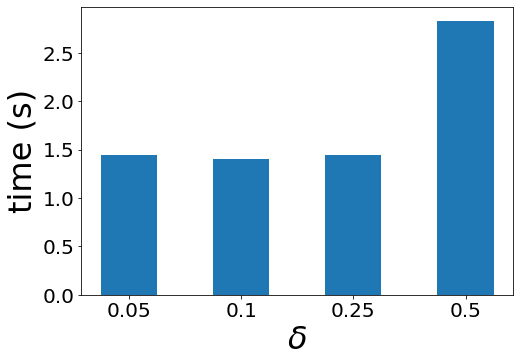





('F(a & X(b))', 'true', 0.05)
                          explanation  extraction time  explanation score  epsilon  delta
 ((a | (b | c)) -> (F (a & (a U b))))       307.528363              100.0     0.05   0.05
   ((b | (a | c)) -> (F (a & (X b))))       220.141602              100.0     0.10   0.05
   ((c | (a | b)) -> (F (a & (X b))))       276.958155              100.0     0.25   0.05
   ((c | (a | b)) -> (F (a & (X b))))       333.024065              100.0     0.50   0.05


<Figure size 432x288 with 0 Axes>

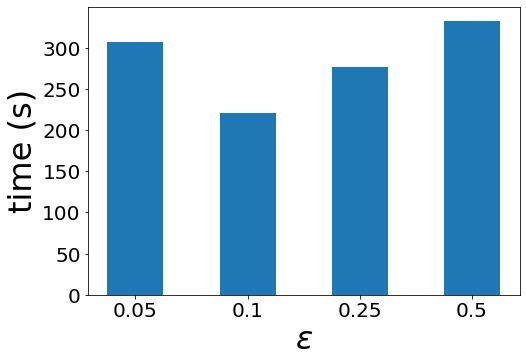





('F(a & X(b))', 'true', 0.05)
                                      explanation  extraction time  explanation score  epsilon  delta
             ((a | (b | c)) -> (F (a & (a U b))))       307.528363              100.0     0.05   0.05
               ((c | (a | b)) -> (F (a & (X b))))       224.432347              100.0     0.05   0.10
       (F ((b | (a | c)) -> ((a U b) & (a | c))))       269.786195              100.0     0.05   0.25
 ((c | (a | b)) -> ((c | (a | b)) U (a & (X b))))       223.859813              100.0     0.05   0.50


<Figure size 432x288 with 0 Axes>

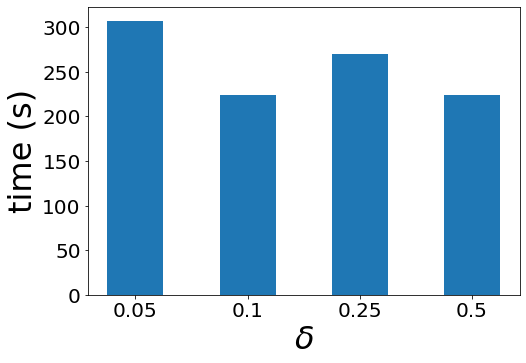





('F(a & X(b))', 'true', 0.1)
                                 explanation  extraction time  explanation score  epsilon  delta
          ((c | (a | b)) -> (F (a & (X b))))       224.432347             100.00     0.05    0.1
          ((a | (b | c)) -> (F (a & (X b))))       258.858820             100.00     0.10    0.1
          ((a | (b | c)) -> (F (a & (X b))))       345.032709             100.00     0.25    0.1
 ((b | (G (a | c))) U (~ (b | (G (a | c)))))       401.121610              53.12     0.50    0.1


<Figure size 432x288 with 0 Axes>

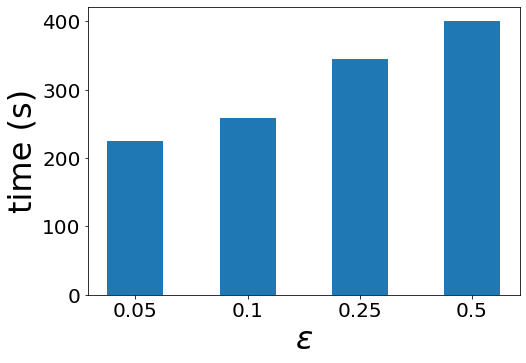





('F(a & X(b))', 'true', 0.1)
                                                          explanation  extraction time  explanation score  epsilon  delta
                                   ((b | (a | c)) -> (F (a & (X b))))       220.141602              100.0      0.1   0.05
                                   ((a | (b | c)) -> (F (a & (X b))))       258.858820              100.0      0.1   0.10
                                   ((c | (a | b)) -> (F (a & (X b))))       239.408509              100.0      0.1   0.25
 ((a | (c | (a U b))) -> ((a | (c | (a U b))) U (a & (c | (a U b)))))       333.368216              100.0      0.1   0.50


<Figure size 432x288 with 0 Axes>

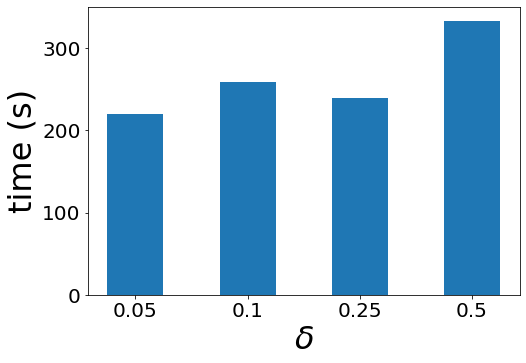





('F(a & X(b))', 'true', 0.25)
                                explanation  extraction time  explanation score  epsilon  delta
 (F ((b | (a | c)) -> ((a U b) & (a | c))))       269.786195              100.0     0.05   0.25
         ((c | (a | b)) -> (F (a & (X b))))       239.408509              100.0     0.10   0.25
         ((c | (a | b)) -> (F (a & (X b))))       269.017182              100.0     0.25   0.25
         ((b | (a | c)) -> (F (a & (X b))))       360.240825              100.0     0.50   0.25


<Figure size 432x288 with 0 Axes>

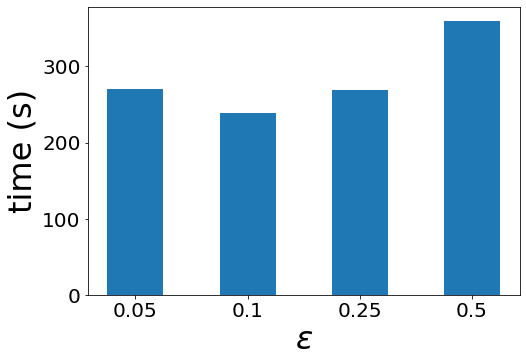





('F(a & X(b))', 'true', 0.25)
                        explanation  extraction time  explanation score  epsilon  delta
 ((c | (a | b)) -> (F (a & (X b))))       276.958155              100.0     0.25   0.05
 ((a | (b | c)) -> (F (a & (X b))))       345.032709              100.0     0.25   0.10
 ((c | (a | b)) -> (F (a & (X b))))       269.017182              100.0     0.25   0.25
 (F ((~ b) & (a U ((a | c) -> b))))       323.843682              100.0     0.25   0.50


<Figure size 432x288 with 0 Axes>

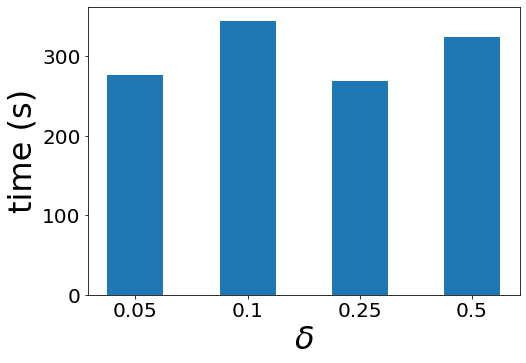





('F(a & X(b))', 'true', 0.5)
                                                          explanation  extraction time  explanation score  epsilon  delta
                     ((c | (a | b)) -> ((c | (a | b)) U (a & (X b))))       223.859813              100.0     0.05    0.5
 ((a | (c | (a U b))) -> ((a | (c | (a U b))) U (a & (c | (a U b)))))       333.368216              100.0     0.10    0.5
                                   (F ((~ b) & (a U ((a | c) -> b))))       323.843682              100.0     0.25    0.5
                                   (F ((c | (a | b)) -> (a & (X b))))       371.099732              100.0     0.50    0.5


<Figure size 432x288 with 0 Axes>

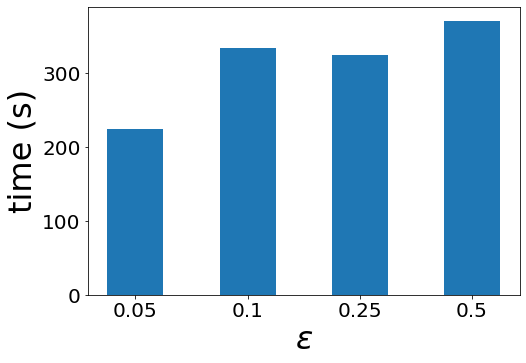





('F(a & X(b))', 'true', 0.5)
                                 explanation  extraction time  explanation score  epsilon  delta
          ((c | (a | b)) -> (F (a & (X b))))       333.024065             100.00      0.5   0.05
 ((b | (G (a | c))) U (~ (b | (G (a | c)))))       401.121610              53.12      0.5   0.10
          ((b | (a | c)) -> (F (a & (X b))))       360.240825             100.00      0.5   0.25
          (F ((c | (a | b)) -> (a & (X b))))       371.099732             100.00      0.5   0.50


<Figure size 432x288 with 0 Axes>

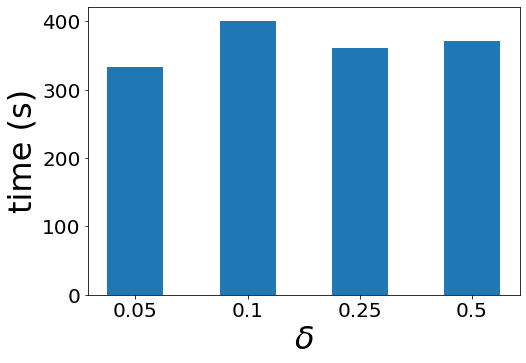

<Figure size 432x288 with 0 Axes>

In [113]:
targets = ["F(a)", "F(aUb)", "F(a & X(b))"]
fixed_param_values = [0.05, 0.1, 0.25, 0.5]

for target in targets:
    for fixed_param_value in fixed_param_values:

        extracted_df=df[(df['target']==target)]
        import matplotlib.pyplot as plt
        plt.rc('pdf', fonttype=42)
        plt.rc('ps', fonttype=42)

        markersize = 20
        fontsize = 32
        labelsize = 20
        width = 0.5

        grouplist=['target','query','delta']
        for key, item in extracted_df.groupby(grouplist):
            _,query,delta=key
            if(delta != fixed_param_value or query != "true"):
                continue
            
            print("\n\n\n")
            print(key)
            
            x_ = 'epsilon'
            
            item = item.sort_values(x_, ascending = True)
            print(item[[ 'explanation','extraction time', 'explanation score', 'epsilon', 'delta']].to_string(index=False))
            
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            ax.bar([i for i in range(len(item[x_].tolist()))],item['extraction time'], width)
            plt.xticks([i for i in range(len(item[x_].tolist()))],item[x_])
            plt.tick_params(labelsize=labelsize)
            plt.ylabel("time (s)", fontsize=fontsize)
            plt.xlabel(r"$"+"\\"+x_+"$", fontsize=fontsize)
            plt.tight_layout()
            if(query=="true"):
                plt.savefig("output/fig/"+target.replace(" ", "")+"_"+query+"_"+x_+"_"+str(int(fixed_param_value*100))+"_time.pdf",bbox_inches='tight')
            plt.show()
            plt.clf()

        grouplist=['target','query','epsilon']
        for key, item in extracted_df.groupby(grouplist):
            _,query,epsilon=key
            if(epsilon != fixed_param_value or query != "true"):
                continue
            
            print("\n\n\n")
            print(key)

            x_ = 'delta'
            
            item = item.sort_values(x_, ascending = True)
            print(item[[ 'explanation','extraction time', 'explanation score', 'epsilon', 'delta']].to_string(index=False))
            
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            ax.bar([i for i in range(len(item[x_].tolist()))],item['extraction time'], width)
            plt.xticks([i for i in range(len(item[x_].tolist()))],item[x_])
            plt.tick_params(labelsize=labelsize)
            plt.ylabel("time (s)", fontsize=fontsize)
            plt.xlabel(r"$"+"\\"+x_+"$", fontsize=fontsize)
            plt.tight_layout()
            if(query=="true"):
                plt.savefig("output/fig/"+target.replace(" ", "")+"_"+query+"_"+x_+"_"+str(int(fixed_param_value*100))+"_time.pdf",bbox_inches='tight')
            plt.show()
            plt.clf()




In [109]:
print("F(a & X(b))".replace(" ", ""))

F(a&X(b))
